# Introducción a la Extracción de Características en CNN

Las Redes Neuronales Convolucionales (CNN) son especialmente eficaces en tareas de visión por computadora debido a su capacidad para extraer y aprender características jerárquicas de las imágenes. La extracción de características se refiere al proceso por el cual una CNN transforma una imagen de entrada en una representación abstracta que resalta las características más relevantes para una tarea específica, como la clasificación o detección de objetos.

En este cuaderno, exploraremos cómo una CNN como VGG16 extrae características de una imagen y visualizaremos estas características para entender mejor cómo funciona el proceso. Usaremos PyTorch para cargar el modelo preentrenado VGG16 y procesar una imagen de ejemplo.

## 1. Importar las bibliotecas necesarias

Comencemos importando las bibliotecas requeridas.



In [1]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


## 2. Cargar el modelo VGG16 preentrenado

Cargaremos el modelo VGG16 preentrenado en el conjunto de datos ImageNet.

In [2]:
model = models.vgg16(pretrained=True)
model.eval()

C:\Users\juano\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\juano\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

- `models.vgg16(pretrained=True)`: Carga el modelo VGG16 con pesos preentrenados en ImageNet.
- `model.eval()`: Configura el modelo en modo de evaluación, desactivando capas como Dropout --> Veremos esto en detalle más adelante en el curso.

## 3. Seleccionar una imagen de ejemplo

Usaremos una imagen de ejemplo para pasar a través de la red y extraer características.

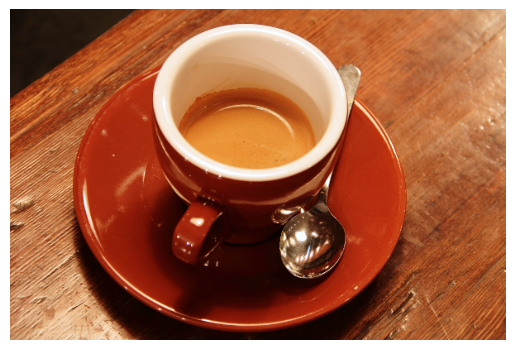

In [3]:
# Ruta de la imagen de ejemplo
from skimage import io, data

# Cargar la imagen
image = data.coffee()
image = Image.fromarray(image)
plt.imshow(image)
plt.axis('off')
plt.show()


## 4. Preprocesar la imagen

Las imágenes deben preprocesarse de la misma manera que durante el entrenamiento del modelo.

In [4]:
# Definir las transformaciones
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Media de ImageNet
        std=[0.229, 0.224, 0.225]    # Desviación estándar de ImageNet
    )
])

# Aplicar las transformaciones
input_tensor = preprocess(image)
# Crear un batch de tamaño 1
input_batch = input_tensor.unsqueeze(0)

- Las transformaciones ajustan la imagen al tamaño y formato esperado por VGG16.
- `transforms.Normalize`: Normaliza la imagen usando la media y desviación estándar de ImageNet.
- `unsqueeze(0)`: Agrega una dimensión extra para representar el batch.

## 5. Definir un hook para extraer características

Usaremos hooks para capturar las salidas de las capas convolucionales.

#### ¿Pero qué es un hook?

En el contexto de redes neuronales con PyTorch, un hook es una función que se adjunta a una capa o módulo de la red para poder realizar ciertas acciones cuando la red está siendo evaluada o entrenada. Existen dos tipos de hooks principales:

- Hooks hacia adelante (forward hooks): Se ejecutan cada vez que una capa calcula su salida, justo después de que se aplica la función forward(). Nos permiten inspeccionar y capturar la salida de una capa sin modificar el modelo.

- Hooks hacia atrás (backward hooks): Se ejecutan durante la propagación hacia atrás, permitiendo monitorear o modificar los gradientes que pasan a través de la red.

En este caso, estamos utilizando forward hooks para capturar las salidas de capas específicas y guardarlas en el diccionario features. Esto nos permite ver qué características la red está extrayendo de la imagen en diferentes etapas de su procesamiento.

In [5]:
# Diccionario para almacenar las características
features = {}

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook


- Creamos una función `get_features` que devuelve un hook.
- El hook almacena la salida de la capa en el diccionario `features`.




## 6. Registrar los hooks en las capas deseadas

Registraremos hooks en algunas capas convolucionales para extraer sus características.

In [6]:
# Registrar hooks en las capas deseadas
model.features[0].register_forward_hook(get_features('conv1_1'))
model.features[5].register_forward_hook(get_features('conv2_1'))
model.features[10].register_forward_hook(get_features('conv3_1'))
model.features[17].register_forward_hook(get_features('conv4_1'))
model.features[24].register_forward_hook(get_features('conv5_1'))


- `model.features` es una lista de las capas de características en VGG16.
- Registramos hooks en las primeras capas de cada bloque convolucional.

## 7. Pasar la imagen a través del modelo

In [7]:
# Verificar si CUDA está disponible y mover los datos al dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
input_batch = input_batch.to(device)

# Pasar la imagen a través del modelo
with torch.no_grad():
    output = model(input_batch)

## 8. Visualizar las características extraídas

Definiremos una función para visualizar los mapas de características.

In [8]:
def visualize_feature_maps(feature_map):
    num_channels = feature_map.shape[1]
    size = feature_map.shape[2]
    cols = 8
    rows = num_channels // cols
    fig = plt.figure(figsize=(20, 20))
    for i in range(num_channels):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(feature_map[0, i].cpu().numpy(), cmap='gray')
        ax.axis('off')
    plt.show()

- La función toma un mapa de características y visualiza cada canal como una imagen en escala de grises.
- Ajusta automáticamente el número de filas y columnas para mostrar todas las características.

### Visualizar las características de la primera capa convolucional

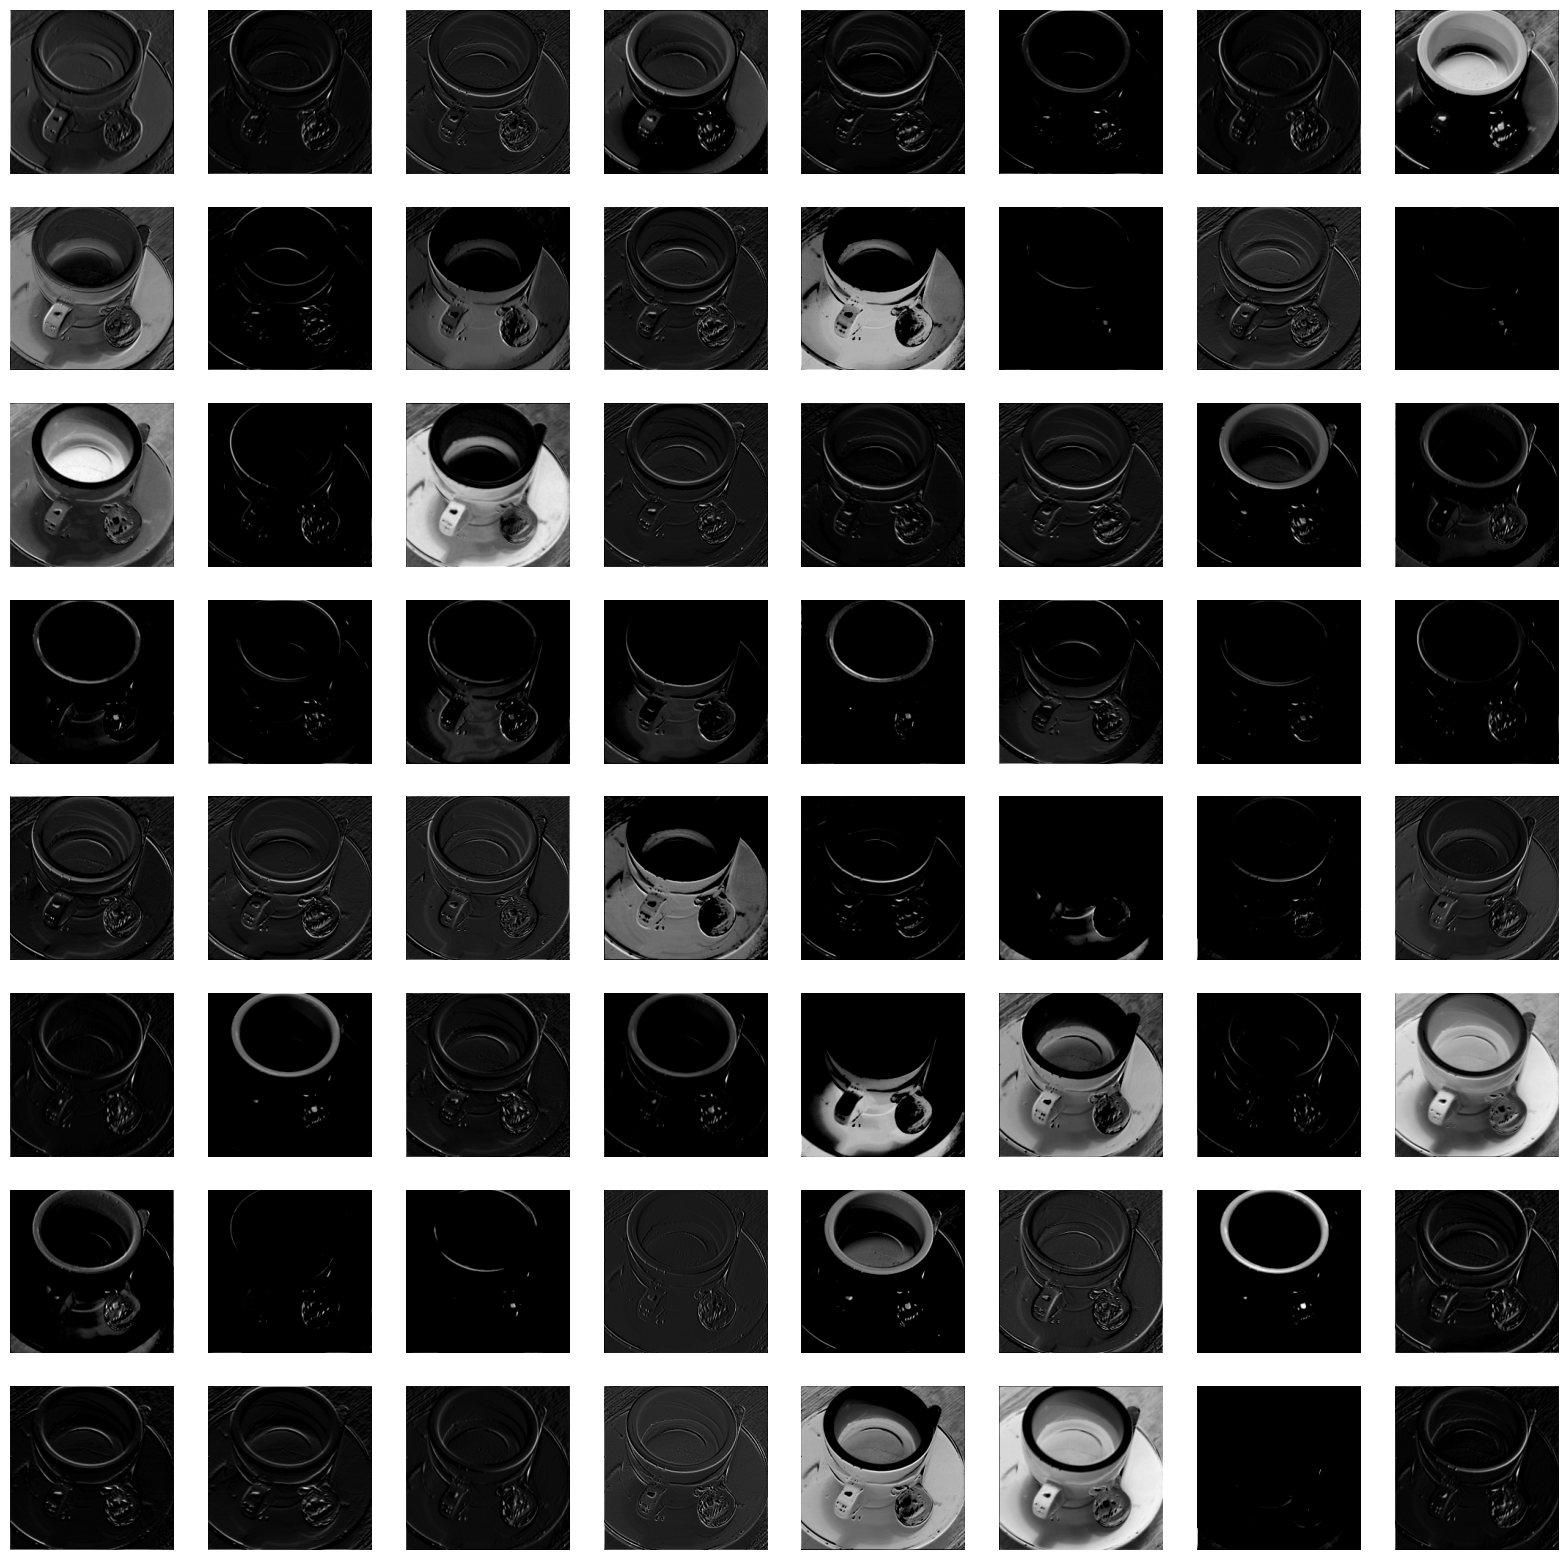

In [9]:
# Visualizar las características de 'conv1_1'
visualize_feature_maps(features['conv1_1'])

- Las características de la primera capa detectan bordes y patrones básicos.
- Los mapas de características muestran activaciones donde el filtro detecta características específicas en la imagen.

### Visualizar las características de capas más profundas

Podemos repetir la visualización para capas más profundas.

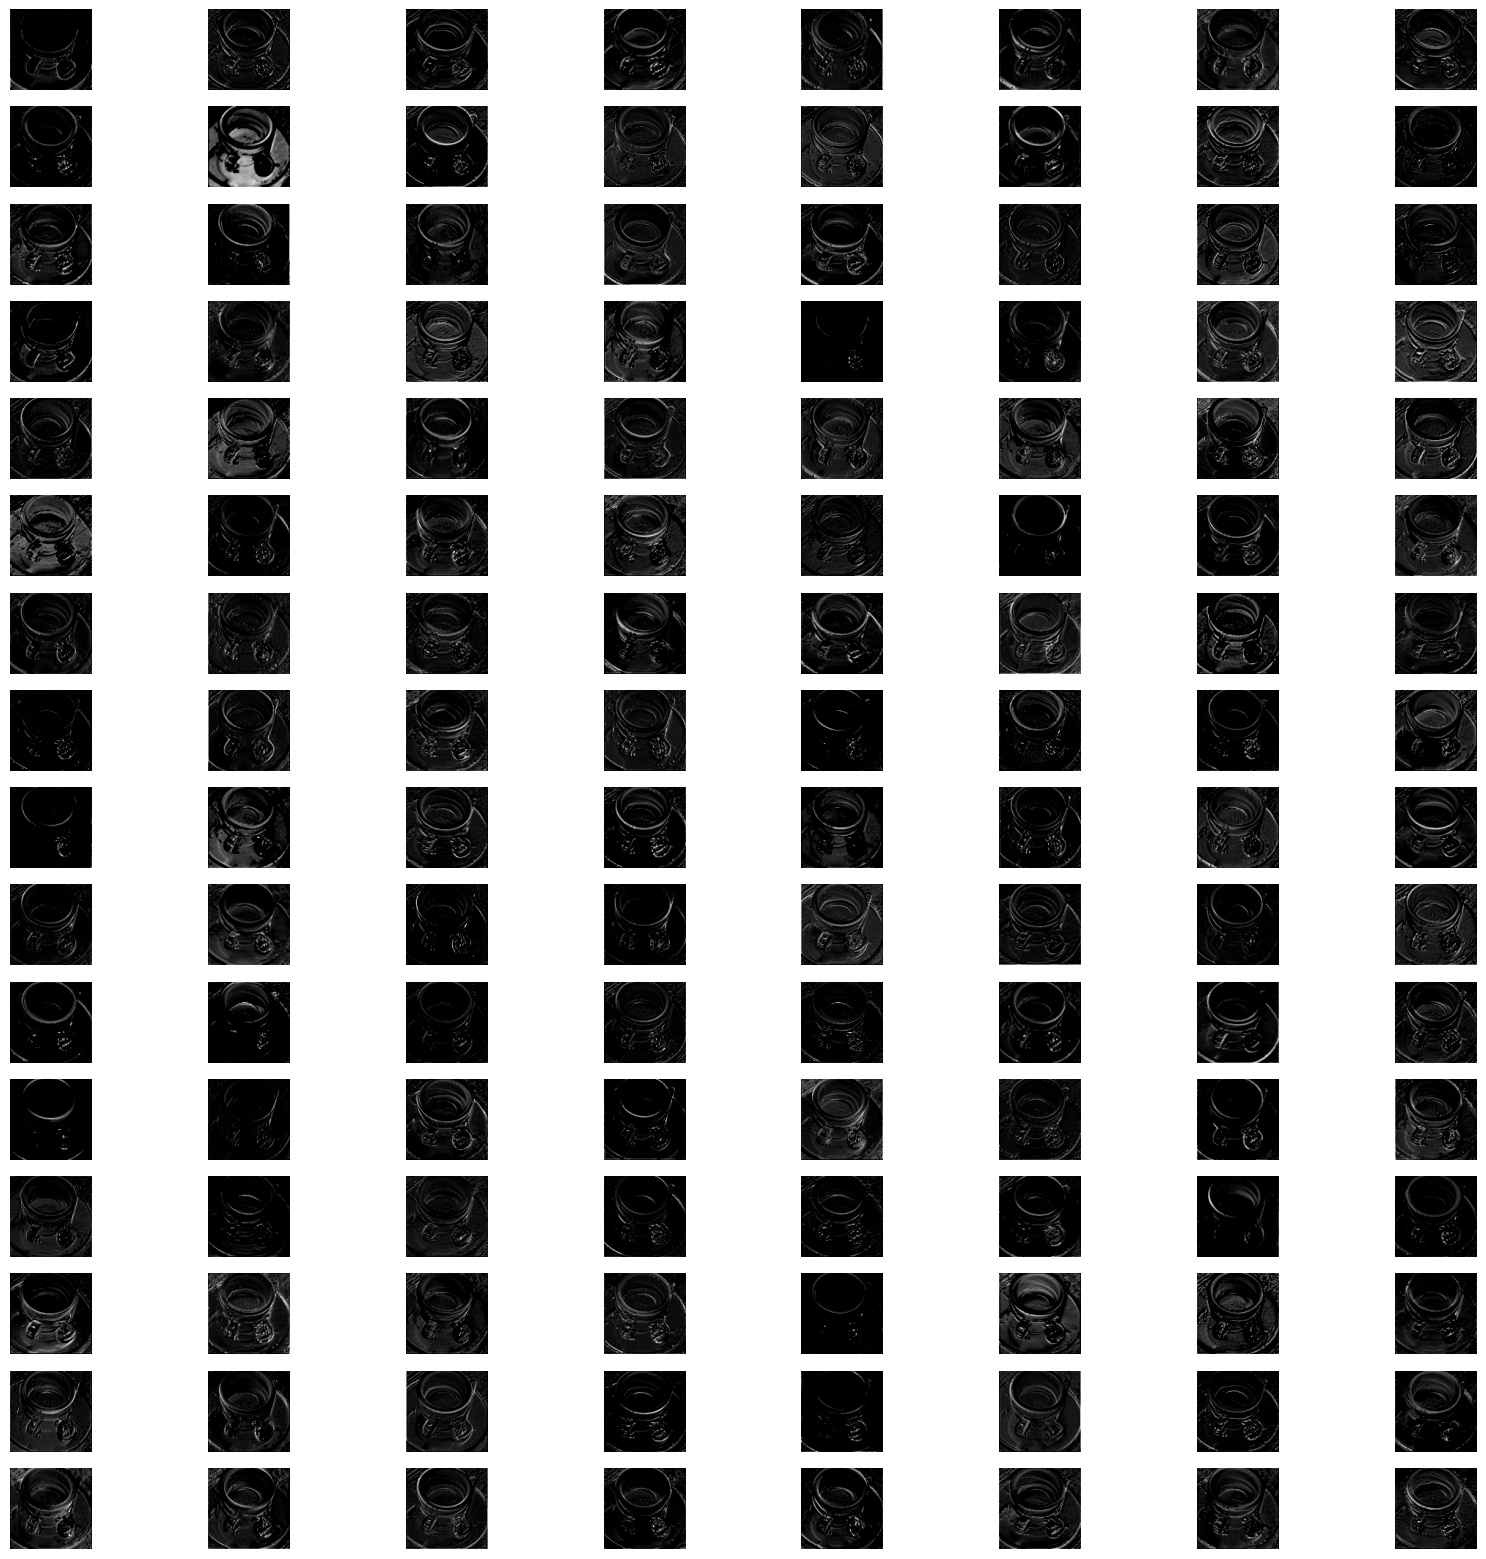

In [10]:
# Visualizar 'conv2_1'
visualize_feature_maps(features['conv2_1'])

- A medida que avanzamos en las capas, las características se vuelven más abstractas.
- Las capas intermedias combinan las características básicas para detectar patrones más complejos.

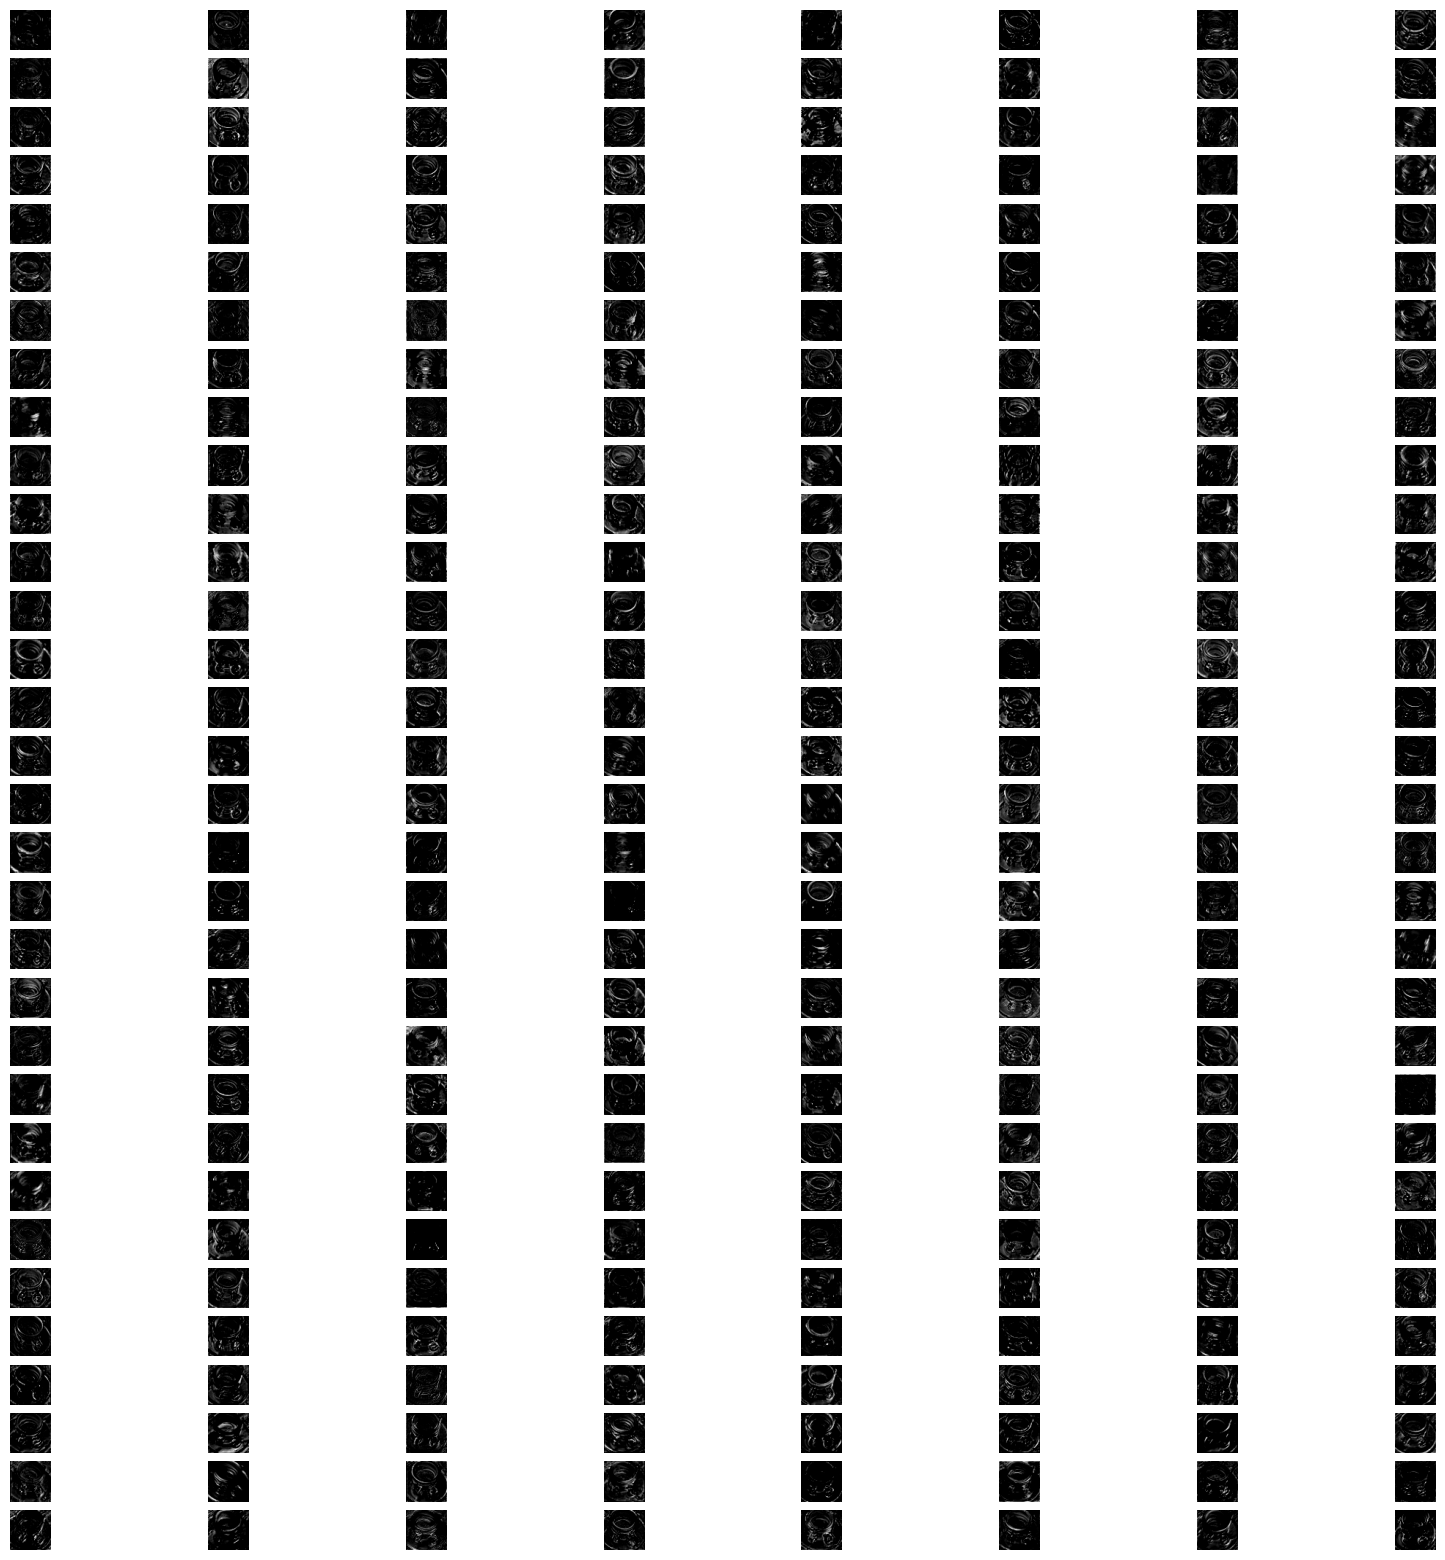

In [11]:
# Visualizar 'conv3_1'
visualize_feature_maps(features['conv3_1'])

- Las características ahora representan partes de objetos o texturas específicas.
- La visualización muestra activaciones más focalizadas.

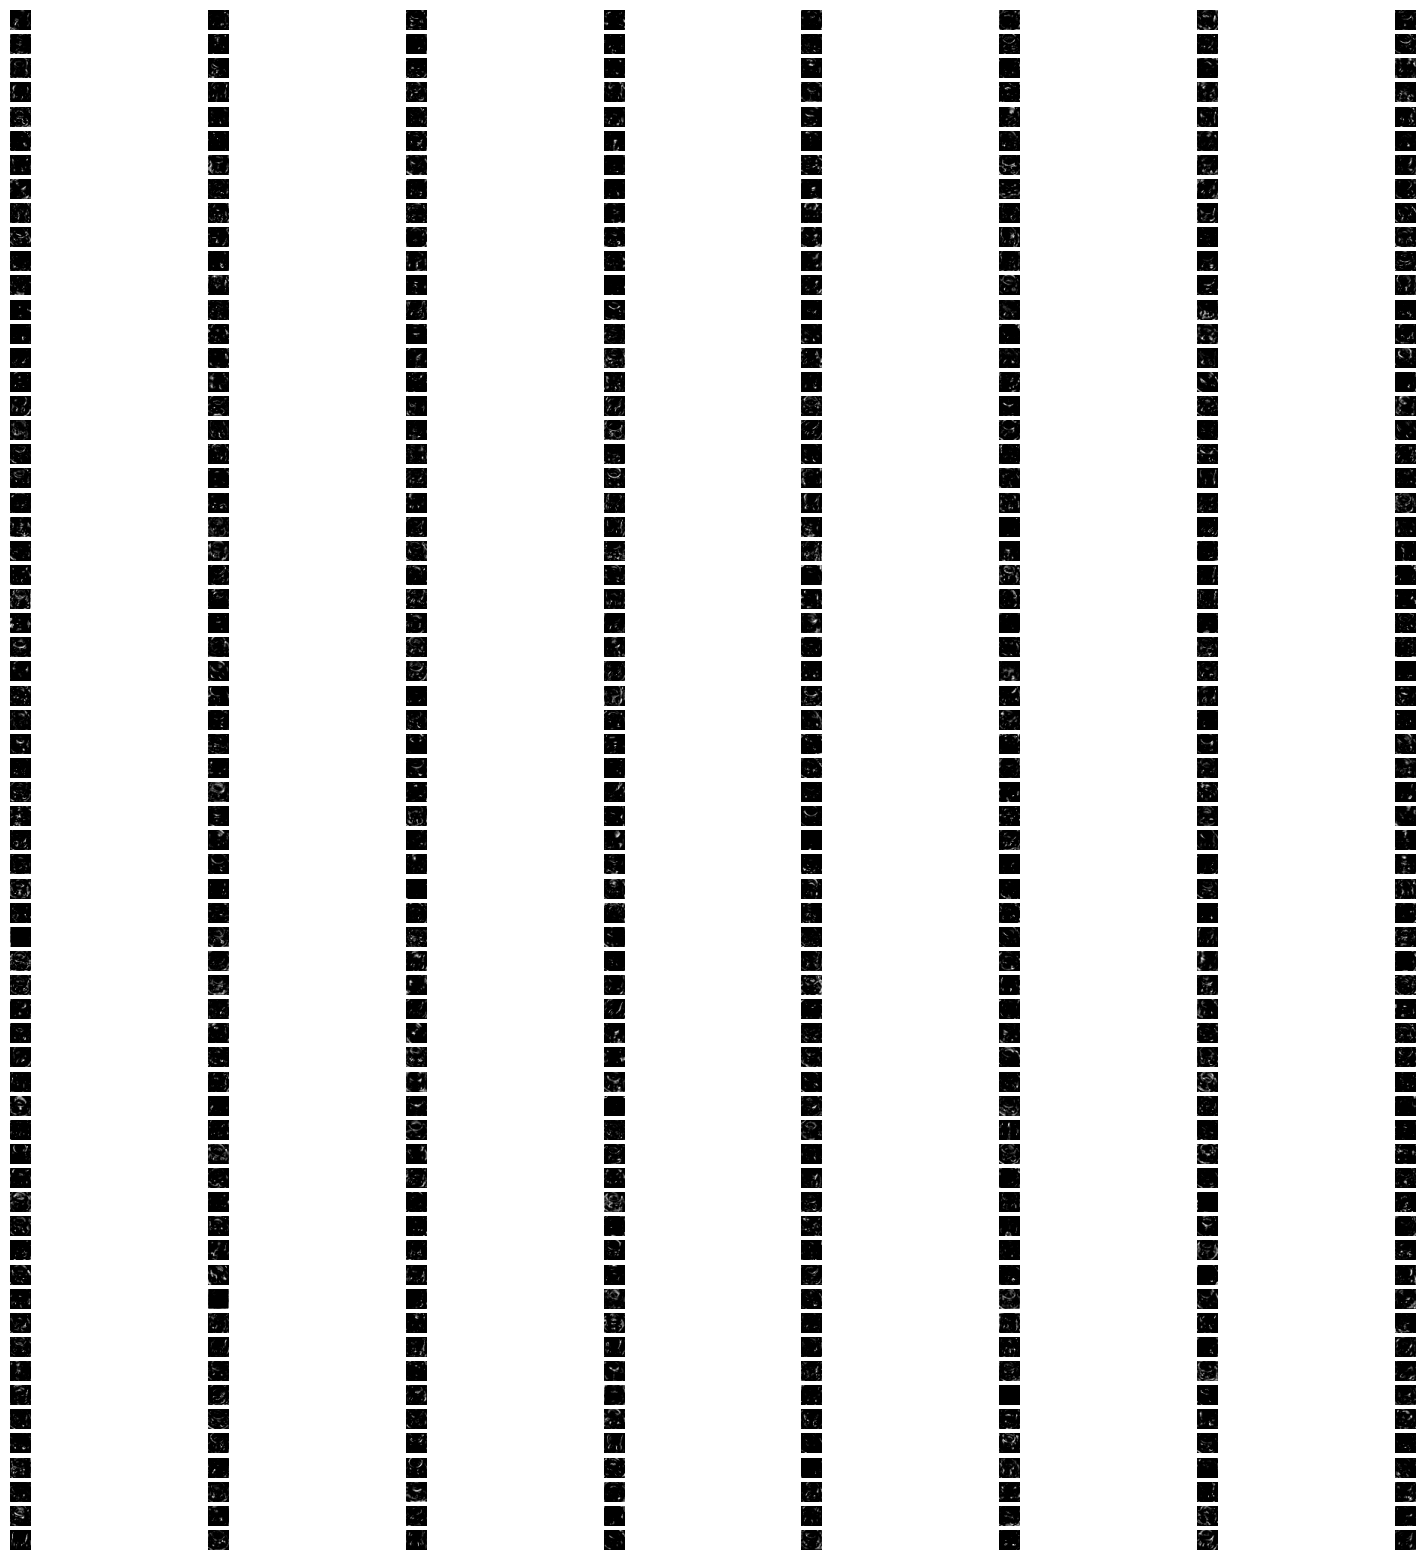

In [12]:
# Visualizar 'conv4_1'
visualize_feature_maps(features['conv4_1'])

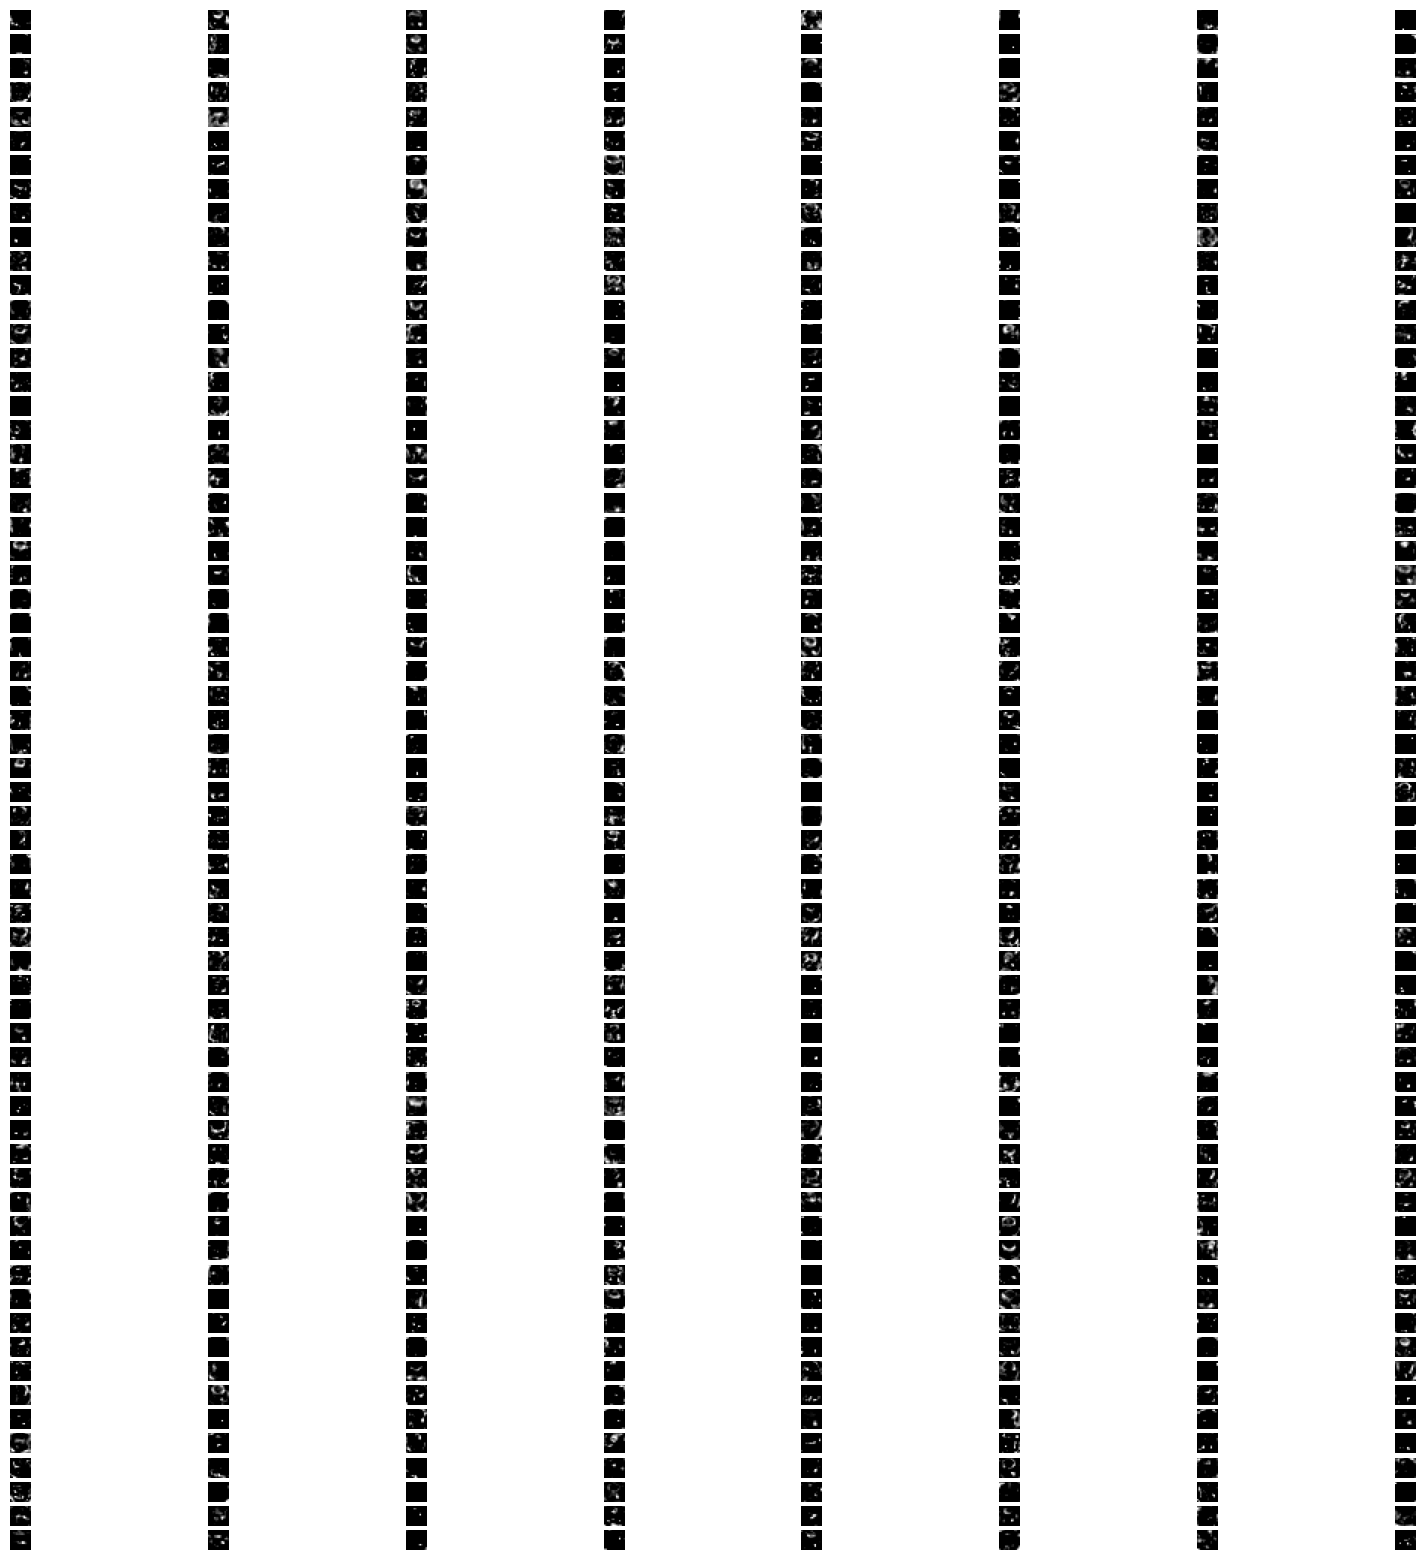

In [13]:
# Visualizar 'conv5_1'
visualize_feature_maps(features['conv5_1'])

## 9. Conclusión

A través de este cuaderno, hemos explorado cómo una CNN como VGG16 extrae características de una imagen. Visualizamos los mapas de características en diferentes capas para entender cómo la red procesa y transforma la información.

- **Capas iniciales**: Detectan características básicas como bordes y texturas simples.
- **Capas intermedias**: Combinan características básicas para detectar patrones más complejos.
- **Capas profundas**: Extraen características de alto nivel representando objetos o partes significativas.

Esta comprensión es fundamental para mejorar modelos existentes y desarrollar nuevas arquitecturas de redes neuronales para tareas específicas en visión por computadora.
